# MLB MVP Predictor
### Author: Adam Bergen
### Date: 10-20-2025

## Description: 
In any sport, the MVP (Most Valuable Player) is one of the most desirable awards for any player and one of the most debated awards among fans. In today's age with superstars such as Aaron Judge, Cal Raleigh, and Shohei Ohtani, fans often have trouble deciding who truly is worthy. Today, we want to leave it to the numbers, look at the stats of previous winners, and determine what stats truly make a winner.

### Import Data and Related Packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pybaseball as pb

# MVP winners (AL + NL) since 2004
mvp_data = [
    # AL
    (2024, "Aaron Judge", "NY Yankees", "OF", "AL"),
    (2023, "Shohei Ohtani", "LA Angels", "DH/SP", "AL"),
    (2022, "Aaron Judge", "NY Yankees", "OF", "AL"),
    (2021, "Shohei Ohtani", "LA Angels", "DH/SP", "AL"),
    (2020, "José Abreu", "Chi White Sox", "1B", "AL"),
    (2019, "Mike Trout", "LA Angels", "CF", "AL"),
    (2018, "Mookie Betts", "Boston", "OF", "AL"),
    (2017, "Jose Altuve", "Houston", "2B", "AL"),
    (2016, "Mike Trout", "LA Angels", "CF", "AL"),
    (2015, "Josh Donaldson", "Toronto", "3B", "AL"),
    (2014, "Mike Trout", "LA Angels", "CF", "AL"),

    # NL
    (2024, "Shohei Ohtani", "LA Dodgers", "DH", "NL"),
    (2023, "Ronald Acuña Jr.", "Atlanta", "OF", "NL"),
    (2022, "Paul Goldschmidt", "St. Louis", "1B", "NL"),
    (2021, "Bryce Harper", "Philadelphia", "OF", "NL"),
    (2020, "Freddie Freeman", "Atlanta", "1B", "NL"),
    (2019, "Cody Bellinger", "LA Dodgers", "RF", "NL"),
    (2018, "Christian Yelich", "Milwaukee", "OF", "NL"),
    (2017, "Giancarlo Stanton", "Miami", "RF", "NL"),
    (2016, "Kris Bryant", "Chi Cubs", "3B", "NL"),
    (2015, "Bryce Harper", "Washington", "RF", "NL"),
    (2014, "Clayton Kershaw", "LA Dodgers", "SP", "NL"),
]

# Convert to DataFrame
mvp_df = pd.DataFrame(mvp_data, columns=["Year", "Player", "Team", "Position", "League"])

### Examine the Data

Here, we will begin to examine the structure of the data to help us get a better idea. Looking at just the heads of the 2025, we can begin to see the structure.

In [2]:
# Get 2025 batting data
bat_2025 = pb.batting_stats(2025)
print(f"2025 Batting Stats: {bat_2025.shape[0]} players")

2025 Batting Stats: 145 players


In [3]:
# Prepare 2025 data
bat_2025_clean = bat_2025.copy()
bat_2025_clean.rename(columns={"Name": "Player", "Season": "Year"}, inplace=True)


In [4]:
# Get historical data (2014-2024)
bat_10years = pb.batting_stats(2014, 2024)
bat_10years.rename(columns={"Name": "Player", "Season": "Year"}, inplace=True)

# Merge with MVP data
merged = pd.merge(bat_10years, mvp_df, on=["Player", "Year"], how="left")
merged["MVP"] = merged["League"].notna().astype(int)
merged.drop(columns=["Team_y", "Position", "League"], inplace=True, errors="ignore")
merged.rename(columns={"Team_x": "Team"}, inplace=True)

print(f"Training data: {merged.shape[0]} players, {merged['MVP'].sum()} MVP winners")


Training data: 1522 players, 19 MVP winners


# Select features for MVP prediction

In [5]:
# Define features for batters
batting_features = [
    "WAR", "wRC+", "OPS", "HR", "RBI", "R", "OBP", "SLG", "AVG",
    "SB", "BB%", "K%", "wOBA"
]

# Filter out rows missing key stats
data = merged[["Player", "Year"] + batting_features + ["MVP"]].dropna()

print("Dataset shape:", data.shape)
print("Features used:", batting_features)
print("MVP winners in data:", data["MVP"].sum())

X = data[batting_features]
y = data["MVP"]
meta = data[["Player", "Year"]]  # to keep track of names

Dataset shape: (1522, 16)
Features used: ['WAR', 'wRC+', 'OPS', 'HR', 'RBI', 'R', 'OBP', 'SLG', 'AVG', 'SB', 'BB%', 'K%', 'wOBA']
MVP winners in data: 19


## Train-Test Split + MLP Model

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Train-test split with stratification
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X, y, meta, test_size=0.2, stratify=y, random_state=42
)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("MVP winners in training:", y_train.sum())
print("MVP winners in test:", y_test.sum())

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


Training set size: 1217
Test set size: 305
MVP winners in training: 15
MVP winners in test: 4


In [7]:
import torch.nn as nn

class MVPNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = MVPNet(X_train.shape[1])


In [8]:
import torch.optim as optim

# Train model
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()


## Evaluation of the Model

In [9]:
# Evaluate model
model.eval()
with torch.no_grad():
    preds = model(X_test_t)
    probs = preds.numpy().flatten()
    pred_binary = (probs > 0.5).astype(int)

# Results
accuracy = (pred_binary == y_test_t.numpy().flatten()).mean()
cm = confusion_matrix(y_test_t.numpy().flatten(), pred_binary)

print(f"Accuracy: {accuracy:.3f}")
print(f"Confusion Matrix: {cm.flatten()}")
print(f"Max probability: {probs.max():.4f}")
print(f"Players with prob > 0.2: {(probs > 0.2).sum()}")


Accuracy: 0.987
Confusion Matrix: [301   0   4   0]
Max probability: 0.3506
Players with prob > 0.2: 115


In [10]:
# Try different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
for threshold in thresholds:
    pred_thresh = (probs > threshold).astype(int)
    cm_thresh = confusion_matrix(y_test_t.numpy().flatten(), pred_thresh)
    accuracy_thresh = (pred_thresh == y_test_t.numpy().flatten()).mean()
    print(f"Threshold {threshold}: Accuracy={accuracy_thresh:.3f}, CM={cm_thresh.flatten()}")


Threshold 0.1: Accuracy=0.167, CM=[ 50 251   3   1]
Threshold 0.2: Accuracy=0.610, CM=[186 115   4   0]
Threshold 0.3: Accuracy=0.941, CM=[287  14   4   0]
Threshold 0.4: Accuracy=0.987, CM=[301   0   4   0]
Threshold 0.5: Accuracy=0.987, CM=[301   0   4   0]


In [11]:
# Create weighted model for imbalanced data
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

class WeightedMVPNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

weighted_model = WeightedMVPNet(X_train.shape[1])
pos_weight = torch.tensor([class_weight_dict[1] / class_weight_dict[0]])
criterion_weighted = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer_weighted = optim.Adam(weighted_model.parameters(), lr=1e-3)

# Train weighted model
for epoch in range(100):
    weighted_model.train()
    optimizer_weighted.zero_grad()
    outputs = weighted_model(X_train_t)
    loss = criterion_weighted(outputs, y_train_t)
    loss.backward()
    optimizer_weighted.step()


In [12]:
# Evaluate weighted model
weighted_model.eval()
with torch.no_grad():
    weighted_preds = weighted_model(X_test_t)
    weighted_probs = weighted_preds.numpy().flatten()
    weighted_pred_binary = (weighted_probs > 0.5).astype(int)

cm_weighted = confusion_matrix(y_test_t.numpy().flatten(), weighted_pred_binary)
accuracy_weighted = (weighted_pred_binary == y_test_t.numpy().flatten()).mean()

print(f"Weighted Model - Accuracy: {accuracy_weighted:.3f}")
print(f"Weighted Model - Max probability: {weighted_probs.max():.4f}")
print(f"Weighted Model - CM: {cm_weighted.flatten()}")


Weighted Model - Accuracy: 0.970
Weighted Model - Max probability: 1.0000
Weighted Model - CM: [295   6   3   1]


In [13]:
# 2025 MVP Predictions
data_2025 = bat_2025_clean[["Player", "Year"] + batting_features].copy().dropna()
X_2025 = data_2025[batting_features]
X_2025_scaled = scaler.transform(X_2025)
X_2025_t = torch.tensor(X_2025_scaled, dtype=torch.float32)

# Make predictions
weighted_model.eval()
with torch.no_grad():
    preds_2025 = weighted_model(X_2025_t)
    probs_2025 = preds_2025.numpy().flatten()

results_2025 = data_2025.copy()
results_2025["MVP_Probability"] = probs_2025

# Top 10 MVP candidates for 2025
top_2025 = results_2025.sort_values("MVP_Probability", ascending=False).head(10)
print("Top 10 MVP Candidates for 2025:")
print(top_2025[["Player", "MVP_Probability", "WAR", "wRC+", "OPS", "HR", "RBI"]].to_string(index=False))


Top 10 MVP Candidates for 2025:
         Player  MVP_Probability  WAR  wRC+   OPS  HR  RBI
    Aaron Judge         0.999997 10.1   204 1.144  53  114
George Springer         0.994686  5.2   166 0.959  32   84
  Shohei Ohtani         0.963418  7.5   172 1.014  55  102
      Juan Soto         0.438224  5.8   156 0.921  43  105
 Corbin Carroll         0.118203  6.5   139 0.883  31   84
Geraldo Perdomo         0.049358  7.1   138 0.851  20  100
   Bryce Harper         0.038600  3.5   131 0.844  27   75
    Ketel Marte         0.032035  4.6   145 0.893  28   72
    Kyle Tucker         0.027377  4.5   136 0.841  22   73
Freddie Freeman         0.022199  3.8   139 0.869  24   90


In [14]:
# Top 5 detailed candidates
print("Top 5 MVP Candidates (Detailed):")
top_5_2025 = results_2025.sort_values("MVP_Probability", ascending=False).head(5)
print(top_5_2025[["Player", "MVP_Probability", "WAR", "wRC+", "OPS", "HR", "RBI", "SB", "AVG"]].to_string(index=False))


Top 5 MVP Candidates (Detailed):
         Player  MVP_Probability  WAR  wRC+   OPS  HR  RBI  SB   AVG
    Aaron Judge         0.999997 10.1   204 1.144  53  114  12 0.331
George Springer         0.994686  5.2   166 0.959  32   84  18 0.309
  Shohei Ohtani         0.963418  7.5   172 1.014  55  102  20 0.282
      Juan Soto         0.438224  5.8   156 0.921  43  105  38 0.263
 Corbin Carroll         0.118203  6.5   139 0.883  31   84  32 0.259


In [15]:
# Feature Importance Analysis
def analyze_feature_importance(model, feature_names):
    first_layer_weights = model.net[0].weight.data.numpy()
    feature_importance = np.sum(np.abs(first_layer_weights), axis=0)
    return pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

weighted_importance = analyze_feature_importance(weighted_model, batting_features)
print("Top 5 Most Important Features:")
print(weighted_importance.head())


Top 5 Most Important Features:
   Feature  Importance
9       SB   22.053694
11      K%   21.503519
10     BB%   20.284885
8      AVG   20.145248
2      OPS   19.811581


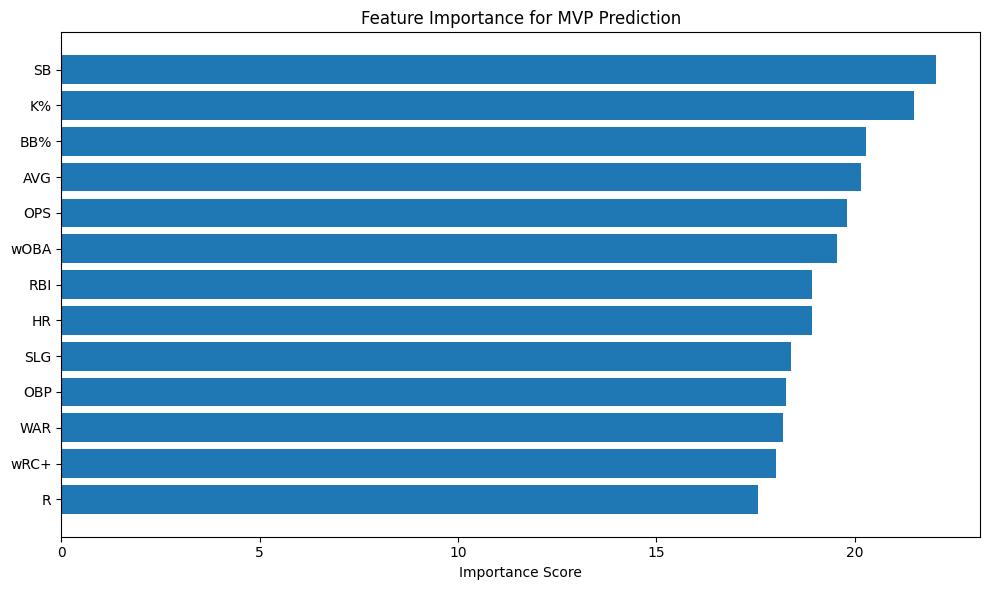

In [16]:
# Simple feature importance visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(range(len(weighted_importance)), weighted_importance['Importance'])
plt.yticks(range(len(weighted_importance)), weighted_importance['Feature'])
plt.xlabel('Importance Score')
plt.title('Feature Importance for MVP Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
